In [2]:
import numpy as np 
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import InceptionResNetV2, DenseNet169, ResNet152V2
from tensorflow.keras.layers import Dense


In [3]:
train_image_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/train_images'
test_image_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/test_images' 
train_df_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/train.csv'
test_df_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/sample_submission.csv'

In [4]:
df_train = pd.read_csv(train_df_path)
df_test=pd.read_csv(test_df_path)

In [5]:
print(df_test)

                  image   labels
0  85f8cb619c66b863.jpg  healthy
1  ad8770db05586b59.jpg  healthy
2  c7b03e718489f3ca.jpg  healthy


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df_train = df_train[(df_train['labels'] == 'healthy') | (df_train['labels'] == 'scab')]

In [8]:
df_train.labels.value_counts()

scab       4826
healthy    4624
Name: labels, dtype: int64

In [9]:
print(df_train)

                      image   labels
0      800113bb65efe69e.jpg  healthy
2      80070f7fb5e2ccaa.jpg     scab
3      80077517781fb94f.jpg     scab
5      800edef467d27c15.jpg  healthy
7      801d6dcd96e48ebc.jpg  healthy
...                     ...      ...
18625  fffaa4a0fe416808.jpg     scab
18626  fffb65761200b054.jpg  healthy
18627  fffb900a92289a33.jpg  healthy
18628  fffc488fa4c0e80c.jpg     scab
18631  fffe472a0001bd25.jpg  healthy

[9450 rows x 2 columns]


<Axes: xlabel='labels', ylabel='count'>

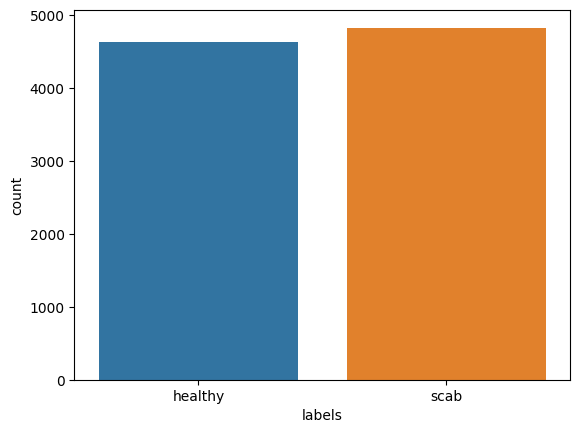

In [10]:
sns.countplot(x = df_train['labels'])

In [11]:
train_df, dummy_df = train_test_split(df_train,  train_size= 0.7, shuffle= True,random_state=123)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.3, shuffle= True,random_state=123)

In [12]:
CLASSES = df_train['labels'].unique().tolist()


In [13]:
print(CLASSES)

['healthy', 'scab']


In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_dataframe(
   train_df, directory= train_image_path, x_col= 'image', y_col= 'labels', target_size= (224,224),
                                            class_mode= 'categorical',shuffle= True, batch_size= 64)
val_generator = train_datagen.flow_from_dataframe(
   valid_df, directory= train_image_path, x_col= 'image', y_col= 'labels', target_size= (224,224),
                                            class_mode= 'categorical', shuffle= True, batch_size= 64)
test_generator = train_datagen.flow_from_dataframe(
   test_df, directory= train_image_path, x_col= 'image', y_col= 'labels', target_size= (224,224),
                                            class_mode= 'categorical',shuffle= False, batch_size= 64)

Found 6611 validated image filenames belonging to 2 classes.
Found 850 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 1984 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [15]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(224,224,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [17]:
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=8,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[earlystop]

In [18]:
c = model.fit(
    train_generator,
    steps_per_epoch = 6611//64,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = (935//64),
    max_queue_size=100,
    workers = 4 ,
    verbose = 1,
callbacks=callbacks)

Epoch 1/10
103/103 [==============================] - 2079s 20s/step - loss: 0.6785 - accuracy: 0.5584 - val_loss: 0.6333 - val_accuracy: 0.6565
Epoch 2/10
103/103 [==============================] - 504s 5s/step - loss: 0.6208 - accuracy: 0.6635 - val_loss: 0.6886 - val_accuracy: 0.5988
Epoch 3/10
103/103 [==============================] - 558s 5s/step - loss: 0.6072 - accuracy: 0.6728 - val_loss: 0.6086 - val_accuracy: 0.6576
Epoch 4/10
103/103 [==============================] - 532s 5s/step - loss: 0.5960 - accuracy: 0.6872 - val_loss: 0.6384 - val_accuracy: 0.6624
Epoch 5/10
103/103 [==============================] - 540s 5s/step - loss: 0.5750 - accuracy: 0.7002 - val_loss: 0.6087 - val_accuracy: 0.6788
Epoch 6/10
103/103 [==============================] - 538s 5s/step - loss: 0.5579 - accuracy: 0.7136 - val_loss: 0.5893 - val_accuracy: 0.6988
Epoch 7/10
103/103 [==============================] - 536s 5s/step - loss: 0.5420 - accuracy: 0.7216 - val_loss: 0.6166 - val_accuracy: 0.66

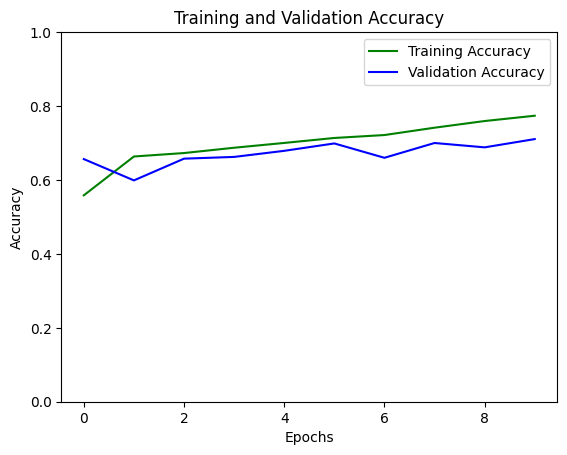

In [19]:
acc_train=c.history['accuracy']
acc_val=c.history['val_accuracy']
epochs=range(len(acc_train))
plt.plot(epochs,acc_train,'g',label='Training Accuracy')
plt.plot(epochs,acc_val,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.ylim(0,1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

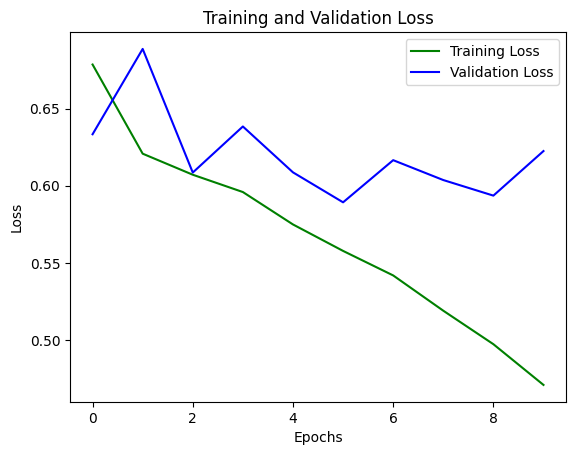

In [20]:
loss_train=c.history['loss']
loss_val=c.history['val_loss']
epochs=range(len(loss_train))
plt.plot(epochs,loss_train,'g',label='Training Loss')
plt.plot(epochs,loss_val,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
train_accuracy = model.evaluate(train_generator,batch_size=128)[1] * 100
print('Train accuracy is : ',train_accuracy, '%' )

104/104 [==============================] - 920s 9s/step - loss: 0.4471 - accuracy: 0.7916
Train accuracy is :  79.15595173835754 %


In [22]:
val_accuracy = model.evaluate(val_generator,batch_size=64)[1] * 100
print('val accuracy is : ',val_accuracy, '%' )

14/14 [==============================] - 113s 8s/step - loss: 0.6225 - accuracy: 0.7106
val accuracy is :  71.05882167816162 %


In [23]:
test_accuracy = model.evaluate(test_generator,batch_size=64)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

31/31 [==============================] - 1900s 63s/step - loss: 0.6031 - accuracy: 0.7031
Test accuracy is :  70.3125 %


In [24]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [25]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model.predict(test_generator, steps = test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)

31/31 [==============================] - 261s 8s/step


In [26]:
import sklearn
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report) 

              precision    recall  f1-score   support

     healthy       0.67      0.77      0.72       966
        scab       0.74      0.64      0.69      1018

    accuracy                           0.70      1984
   macro avg       0.71      0.70      0.70      1984
weighted avg       0.71      0.70      0.70      1984



<Figure size 200x200 with 0 Axes>

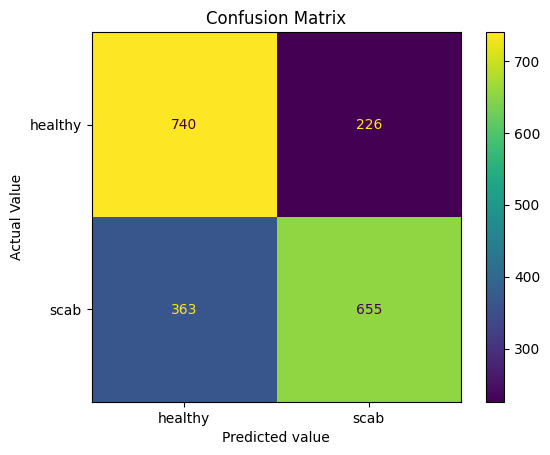

In [27]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
x=confusion_matrix(true_classes, predicted_classes)

x_display=metrics.ConfusionMatrixDisplay(confusion_matrix=x,display_labels=class_labels)
plt.figure(figsize=(2,2))
x_display.plot()

plt.title("Confusion Matrix")
plt.xlabel("Predicted value")
plt.ylabel("Actual Value")
plt.show()

In [28]:
! pip install scikit-plot



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


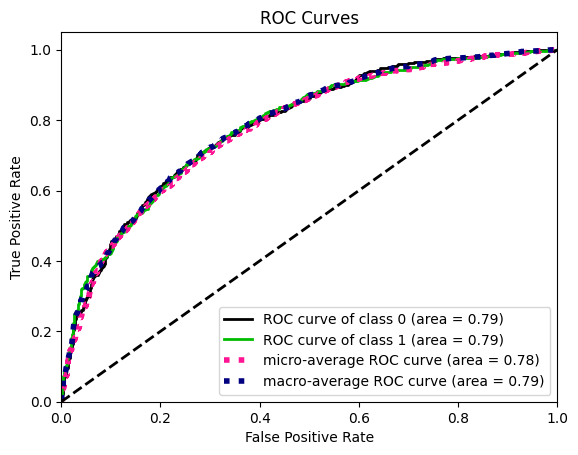

<Figure size 200x200 with 0 Axes>

In [29]:
import scikitplot as skplt

y_true = true_classes
y_probas = predictions
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.figure(figsize=(2,2))
plt.show()